# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_AD2_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for AD2 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_AD2_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# AD2_twas = fread("~/project/image_QTL/twas/multiple_testing/image_AD2_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
AD2_twas = fread("~/project/image_QTL/twas/image_AD2_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [7]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [8]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- AD2_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [9]:
head(AD2_twas)
dim(AD2_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,enet,TRUE,FALSE,0.098757440,8.923911e-10,2.492697,0.01267771,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,lasso,TRUE,FALSE,0.103370596,3.541036e-10,2.475217,0.01331554,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,mrash,TRUE,FALSE,0.089177838,6.013310e-09,2.493315,0.01265565,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,susie,TRUE,TRUE,0.121638427,8.766557e-12,2.505183,0.01223882,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD2,enet,TRUE,FALSE,0.007872702,5.201216e-02,1.830248,0.06721286,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD2,lasso,TRUE,FALSE,0.006195072,7.447581e-02,1.827701,0.06759438,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 903842     19

In [5]:
# Strong and reliable TWAS signals:
AD2_twas_filtered <- AD2_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
AD2_block = unique(AD2_twas_filtered$block)

In [7]:
dim(AD2_twas_filtered)

[1] 817  19

In [9]:
most_likely_causal_genes = AD2_twas_filtered |> 
  group_by(context, region) |> 
  slice_max(twas_z, n = 1)

In [10]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
11,ENSG00000110492,46380755,45380755,48440000,AC_DeJager_eQTL,image_AD2,mvsusie,TRUE,FALSE,0.05292778,8.709874e-09,-5.012974,5.359513e-07,eQTL,chr11_44270671_46916060,chr11_44270671_46916060,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr11_44270671_46916060.twas.tsv.gz
11,ENSG00000110108,60914157,57280000,61923443,AC_DeJager_eQTL,image_AD2,mrash,TRUE,FALSE,0.01883097,4.717748e-04,-4.723397,2.319373e-06,eQTL,chr11_60339997_63818332,chr11_60339997_63818332,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr11_60339997_63818332.twas.tsv.gz
12,ENSG00000088992,117099478,115920000,118120000,AC_DeJager_eQTL,image_AD2,bayes_l,TRUE,FALSE,0.20059666,8.144650e-31,6.854376,7.162463e-12,eQTL,chr12_115165608_117668628,chr12_115165608_117668628,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr12_115165608_117668628.twas.tsv.gz
12,ENSG00000111490,64759483,63560000,66160000,AC_DeJager_eQTL,image_AD2,bayes_l,TRUE,FALSE,0.03614365,1.858085e-06,5.941566,2.823127e-09,eQTL,chr12_61991992_65677087,chr12_61991992_65677087,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr12_61991992_65677087.twas.tsv.gz
17,ENSG00000161714,45133353,42560000,46680000,AC_DeJager_eQTL,image_AD2,mvsusie,TRUE,FALSE,0.08231760,6.384749e-13,4.959055,7.083706e-07,eQTL,chr17_42087601_45383525,chr17_42087601_45383525,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr17_42087601_45383525.twas.tsv.gz
17,ENSG00000120088,45784279,42560000,46835828,AC_DeJager_eQTL,image_AD2,mrash,TRUE,FALSE,0.01010393,8.173605e-03,4.745944,2.075361e-06,eQTL,chr17_45383525_50162864,chr17_45383525_50162864,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr17_45383525_50162864.twas.tsv.gz


[1] 186  19

In [14]:
most_likely_causal_genes |> count(molecular_id) |> nrow()

[1] 93

In [11]:
AD2_gene = unique(most_likely_causal_genes$molecular_id)

In [12]:
image_AD2_gene_list <- AD2_twas |> 
  dplyr::filter(molecular_id %in% AD2_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), molecular_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, molecular_id) |> 
  unique()

In [13]:
dim(image_AD2_gene_list)

[1] 92  4

In [14]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [15]:
image_AD2_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_AD2")) |> dplyr::select(-strand,-event_ID)
                                        

In [16]:
image_AD2_gene = bind_rows(image_AD2_gene_list, image_AD2_QTL_gene)

In [17]:
fwrite(image_AD2_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD2_gene_list.tsv", sep = '\t')

### image_AD2_QTL list

In [18]:

library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are

In [19]:
image_AD2_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD2_gene_list.tsv")
AD2_gene = image_AD2_gene |> filter(gene_name == '')  |> pull(molecular_id)

In [20]:
AD2_sig_gene_ego <- enrichGO(
  gene          = unique(image_AD2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [21]:
head(AD2_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051580,GO:0051580,regulation of neurotransmitter uptake,3/84,28/21261,0.0001814726,0.1376954,0.1243888,ENSG00000089250/ENSG00000137312/ENSG00000131095,3
GO:0009048,GO:0009048,dosage compensation by inactivation of X chromosome,3/84,34/21261,0.0003258618,0.1376954,0.1243888,ENSG00000012048/ENSG00000120071/ENSG00000025293,3
GO:0007549,GO:0007549,dosage compensation,3/84,36/21261,0.0003866041,0.1376954,0.1243888,ENSG00000012048/ENSG00000120071/ENSG00000025293,3
GO:0045732,GO:0045732,positive regulation of protein catabolic process,6/84,250/21261,0.0004704986,0.1376954,0.1243888,ENSG00000165912/ENSG00000185104/ENSG00000135119/ENSG00000174989/ENSG00000073969/ENSG00000137331,6
GO:1901875,GO:1901875,positive regulation of post-translational protein modification,5/84,170/21261,0.0005714712,0.1376954,0.1243888,ENSG00000012048/ENSG00000120071/ENSG00000025293/ENSG00000136560/ENSG00000145901,5
GO:0031281,GO:0031281,positive regulation of cyclase activity,3/84,45/21261,0.0007489098,0.1376954,0.1243888,ENSG00000089250/ENSG00000102882/ENSG00000120088,3
GO:0060020,GO:0060020,Bergmann glial cell differentiation,2/84,11/21261,0.0008289357,0.1376954,0.1243888,ENSG00000102882/ENSG00000131095,2
GO:0085020,GO:0085020,protein K6-linked ubiquitination,2/84,11/21261,0.0008289357,0.1376954,0.1243888,ENSG00000012048/ENSG00000109332,2
GO:0090085,GO:0090085,regulation of protein deubiquitination,2/84,11/21261,0.0008289357,0.1376954,0.1243888,ENSG00000136560/ENSG00000145901,2


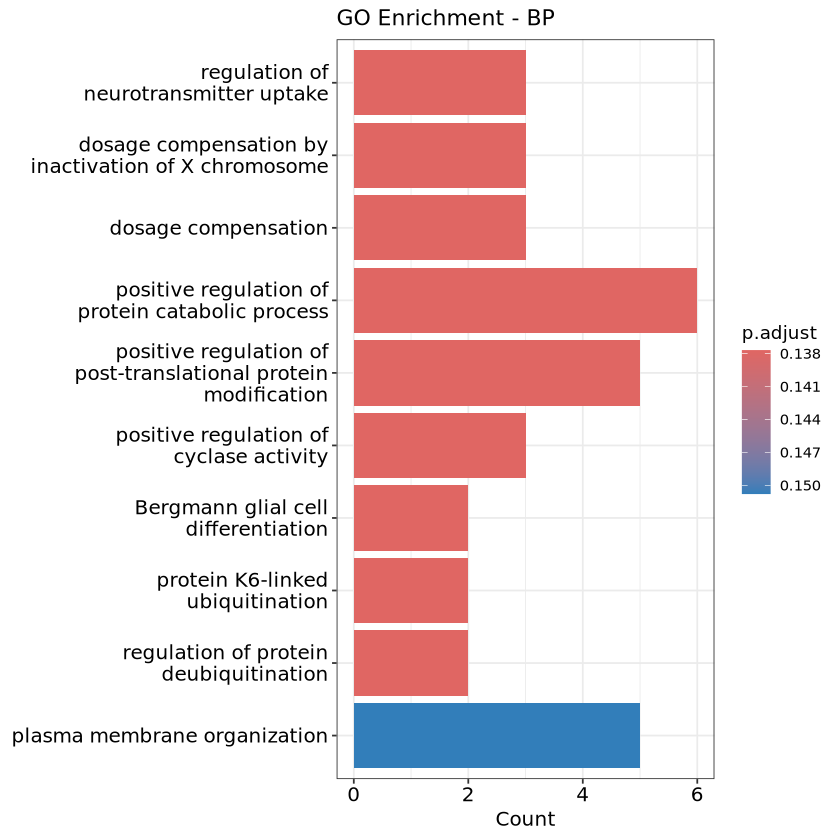

In [22]:
barplot(AD2_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [23]:
AD2_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_AD2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [24]:
head(AD2_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044545,GO:0044545,NSL complex,2/87,13/22568,0.001114682,0.1472275,0.1298934,ENSG00000120071/ENSG00000025293,2
GO:0001741,GO:0001741,XY body,2/87,16/22568,0.001702052,0.1472275,0.1298934,ENSG00000143194/ENSG00000012048,2
GO:0000930,GO:0000930,gamma-tubulin complex,2/87,20/22568,0.002668066,0.1538585,0.1357437,ENSG00000131462/ENSG00000012048,2
GO:0036064,GO:0036064,ciliary basal body,4/87,181/22568,0.005310867,0.1946532,0.1717354,ENSG00000111490/ENSG00000126001/ENSG00000174989/ENSG00000131462,4
GO:0005814,GO:0005814,centriole,4/87,184/22568,0.005625816,0.1946532,0.1717354,ENSG00000176155/ENSG00000126001/ENSG00000174989/ENSG00000131462,4
GO:0031252,GO:0031252,cell leading edge,6/87,461/22568,0.008835297,0.2382631,0.2102108,ENSG00000088992/ENSG00000088280/ENSG00000115306/ENSG00000137312/ENSG00000131462/ENSG00000108852,6
GO:0000803,GO:0000803,sex chromosome,2/87,42/22568,0.011445062,0.2382631,0.2102108,ENSG00000143194/ENSG00000012048,2
GO:0071339,GO:0071339,MLL1 complex,2/87,44/22568,0.012512599,0.2382631,0.2102108,ENSG00000120071/ENSG00000025293,2
GO:0044665,GO:0044665,MLL1/2 complex,2/87,45/22568,0.013062093,0.2382631,0.2102108,ENSG00000120071/ENSG00000025293,2


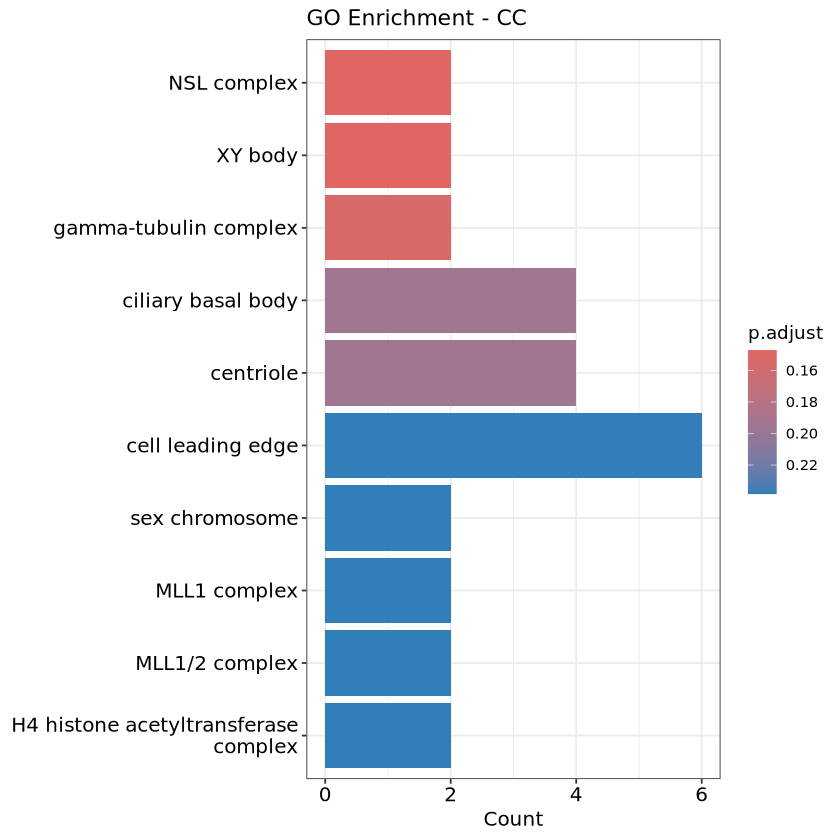

In [25]:
barplot(AD2_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [26]:
image_AD2_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_AD2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [27]:
head(image_AD2_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004435,GO:0004435,phosphatidylinositol phospholipase C activity,2/84,29/21059,0.005951996,0.3583969,0.3353422,ENSG00000115556/ENSG00000161714,2
GO:0008081,GO:0008081,phosphoric diester hydrolase activity,3/84,97/21059,0.006893817,0.3583969,0.3353422,ENSG00000115556/ENSG00000102886/ENSG00000161714,3
GO:0004629,GO:0004629,phospholipase C activity,2/84,32/21059,0.007215380,0.3583969,0.3353422,ENSG00000115556/ENSG00000161714,2
GO:0035255,GO:0035255,ionotropic glutamate receptor binding,2/84,35/21059,0.008588918,0.3583969,0.3353422,ENSG00000137312/ENSG00000073969,2
GO:0004620,GO:0004620,phospholipase activity,3/84,117/21059,0.011491130,0.3583969,0.3353422,ENSG00000115556/ENSG00000102886/ENSG00000161714,3
GO:0005200,GO:0005200,structural constituent of cytoskeleton,3/84,129/21059,0.014923229,0.3583969,0.3353422,ENSG00000115306/ENSG00000131462/ENSG00000131095,3
GO:0019887,GO:0019887,protein kinase regulator activity,4/84,249/21059,0.017619589,0.3583969,0.3353422,ENSG00000088992/ENSG00000185104/ENSG00000115592/ENSG00000204435,4
GO:0016298,GO:0016298,lipase activity,3/84,143/21059,0.019584885,0.3583969,0.3353422,ENSG00000115556/ENSG00000102886/ENSG00000161714,3
GO:0035254,GO:0035254,glutamate receptor binding,2/84,56/21059,0.021063710,0.3583969,0.3353422,ENSG00000137312/ENSG00000073969,2


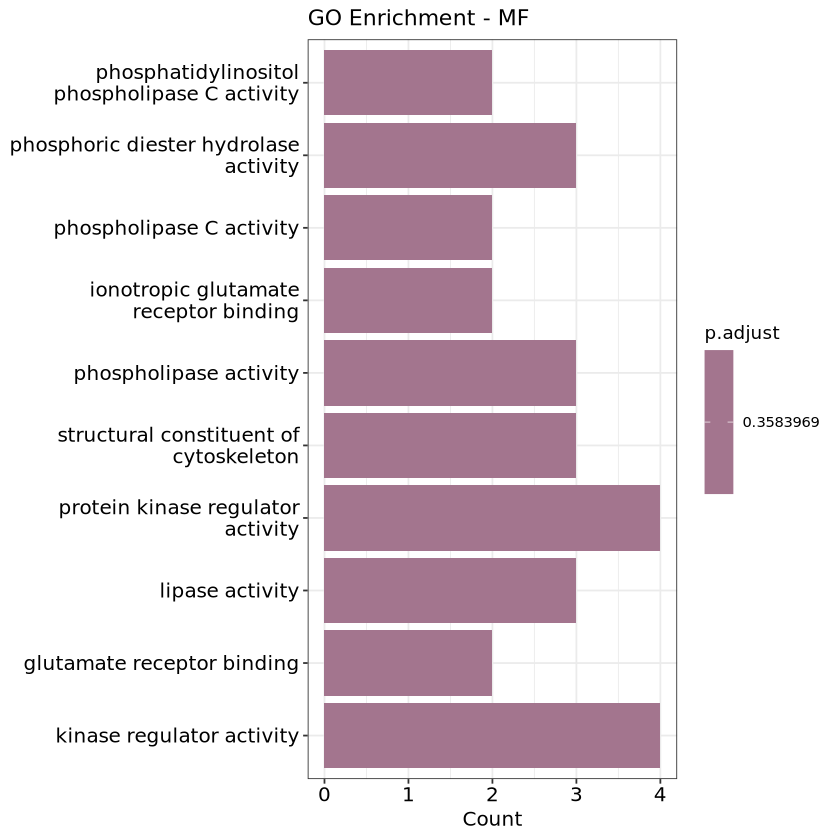

In [28]:
barplot(image_AD2_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [29]:
entrez_ids <- bitr(image_AD2_gene$molecular_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(image_AD2_gene$molecular_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“3.23% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [30]:
kegg_enrich %>% head(n=20)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04730,Organismal Systems,Nervous system,hsa04730,Long-term depression,3/33,60/9446,0.001160843,0.1497516,0.1415116,4842/5595/1394,3
hsa05131,Human Diseases,Infectious disease: bacterial,hsa05131,Shigellosis,5/33,253/9446,0.001701722,0.1497516,0.1415116,5595/84812/113026/7323/10318,5
hsa04933,Human Diseases,Endocrine and metabolic disease,hsa04933,AGE-RAGE signaling pathway in diabetic complications,3/33,101/9446,0.005129595,0.2861380,0.2703936,5595/84812/113026,3
hsa04350,Environmental Information Processing,Signal transduction,hsa04350,TGF-beta signaling pathway,3/33,110/9446,0.006503137,0.2861380,0.2703936,23592/5595/8200,3
hsa04919,Organismal Systems,Endocrine system,hsa04919,Thyroid hormone signaling pathway,3/33,122/9446,0.008647475,0.2871594,0.2713588,5595/84812/113026,3
hsa04910,Organismal Systems,Endocrine system,hsa04910,Insulin signaling pathway,3/33,138/9446,0.012086483,0.2871594,0.2713588,5595/10211/53632,3
hsa04371,Environmental Information Processing,Signal transduction,hsa04371,Apelin signaling pathway,3/33,140/9446,0.012564200,0.2871594,0.2713588,4842/5595/53632,3
hsa04120,Genetic Information Processing,"Folding, sorting and degradation",hsa04120,Ubiquitin mediated proteolysis,3/33,142/9446,0.013052700,0.2871594,0.2713588,26259/672/7323,3
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,3/33,169/9446,0.020718928,0.4051702,0.3828761,5595/10010/9842,3


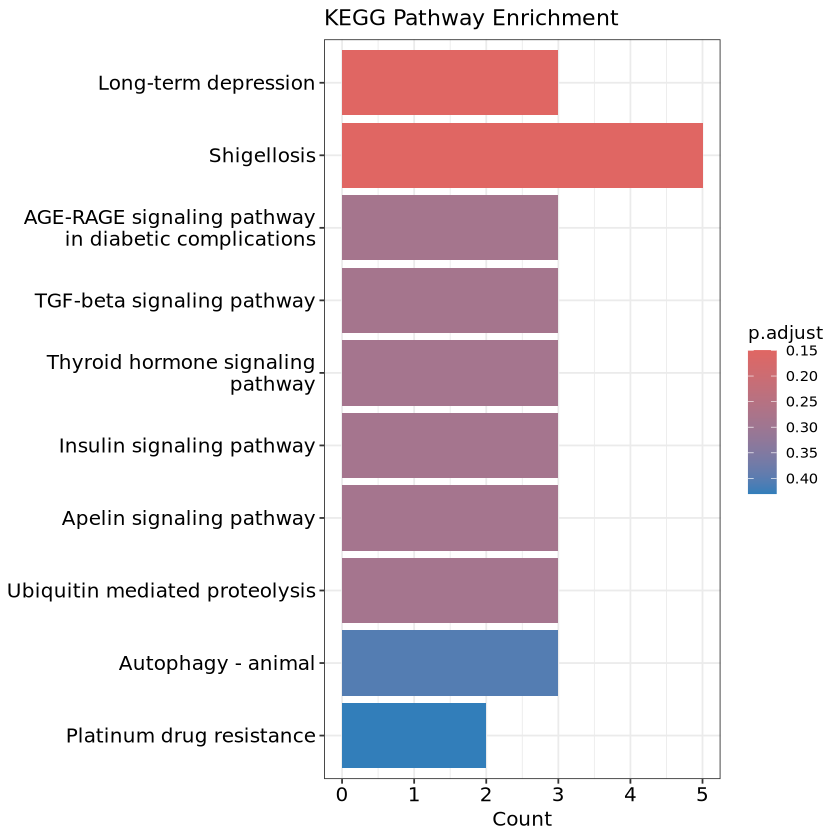

In [31]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")